In [1]:
from datetime import datetime

import hvpy
import matplotlib.pyplot as plt
from hvpy.datasource import DataSource

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.data.sample
from sunpy.coordinates import Helioprojective
from sunpy.map import Map
from sunpy.util.config import get_and_create_download_dir

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


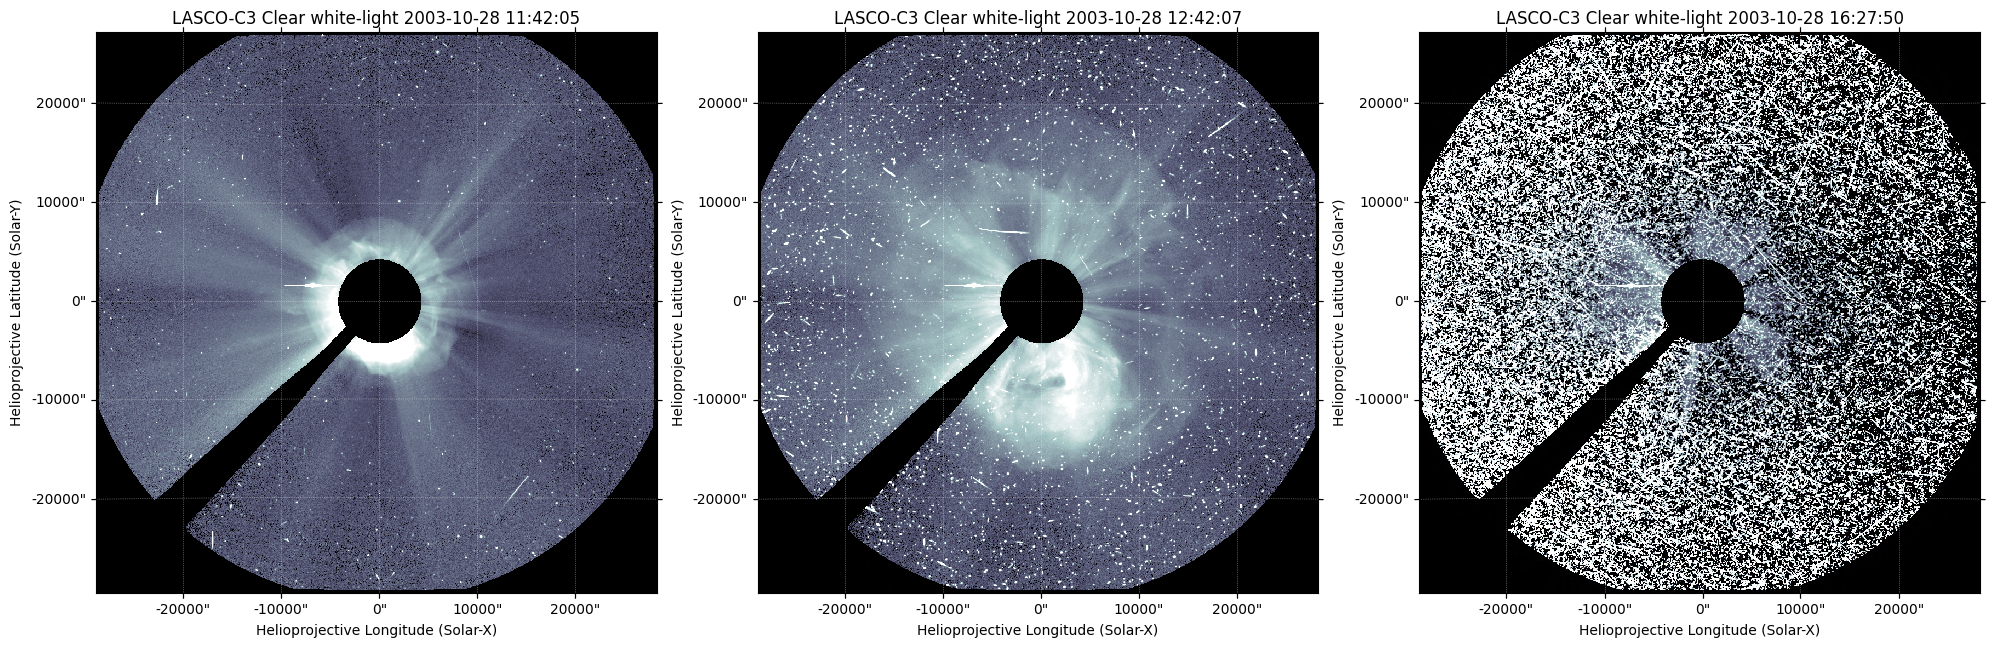

In [127]:
lasco_jp2_file0 = hvpy.save_file(hvpy.getJP2Image(datetime(2003, 10, 28, 12, 0),
                                                 DataSource.LASCO_C3.value),
                                 filename=get_and_create_download_dir()+'/LASCO0_C2.jp2', overwrite=True)

lasco_jp2_file1 = hvpy.save_file(hvpy.getJP2Image(datetime(2003, 10, 28, 12, 50),
                                                 DataSource.LASCO_C3.value),
                                 filename=get_and_create_download_dir()+'/LASCO1_C2.jp2', overwrite=True)

lasco_jp2_file2 = hvpy.save_file(hvpy.getJP2Image(datetime(2003, 10, 28, 16, 27),
                                                 DataSource.LASCO_C3.value),
                                 filename=get_and_create_download_dir()+'/LASCO2_C2.jp2', overwrite=True)

lasco_map0 = Map(lasco_jp2_file0)
lasco_map1 = Map(lasco_jp2_file1)
lasco_map2 = Map(lasco_jp2_file2)

fig = plt.figure(figsize=[20,8])

ax = fig.add_subplot(1, 3, 1, projection=lasco_map0)
lasco_map0.plot(axes=ax)

ax = fig.add_subplot(1, 3, 2, projection=lasco_map1)
lasco_map1.plot(axes=ax)

ax = fig.add_subplot(1, 3, 3, projection=lasco_map2)
lasco_map2.plot(axes=ax)

plt.tight_layout()
fig.savefig('./LASCO_C3_SEP.png', bbox_inches='tight')
plt.show()

In [3]:
lasco_jp2_file = hvpy.save_file(hvpy.getJP2Image(datetime(2011, 6, 7, 6, 34),
                                                 DataSource.LASCO_C2.value),
                                filename=get_and_create_download_dir() + '/LASCO_C2.jp2', overwrite=True)
lasco_map = Map(lasco_jp2_file)
aia_map = Map(sunpy.data.sample.AIA_171_IMAGE)

In [4]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)
projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)
# We use `assume_spherical_screen` to ensure that the off limb AIA pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

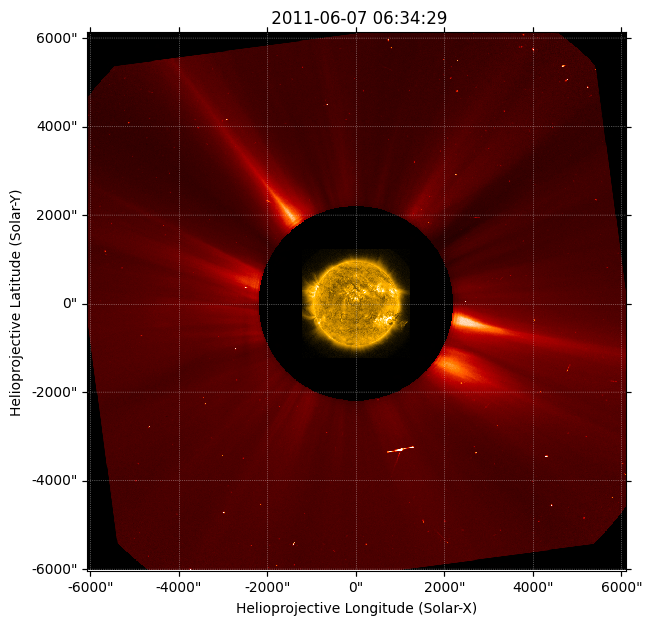

In [8]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
aia_reprojected.plot(axes=ax, clip_interval=(1, 99.9)*u.percent, autoalign=True)
#ax.set_title('AIA and LASCO C2 Overlay')
plt.show()

### My Data

In [162]:
select_year = 2022
select_month = 6
select_day = 13
select_hour = 4
select_minute = 12

In [163]:
# get LASCO
lasco_jp2_file = hvpy.save_file(hvpy.getJP2Image(datetime(select_year, select_month, select_day, select_hour, select_minute),
                                                 DataSource.LASCO_C2.value),
                                filename=get_and_create_download_dir() + '/LASCO_C2.jp2', overwrite=True)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


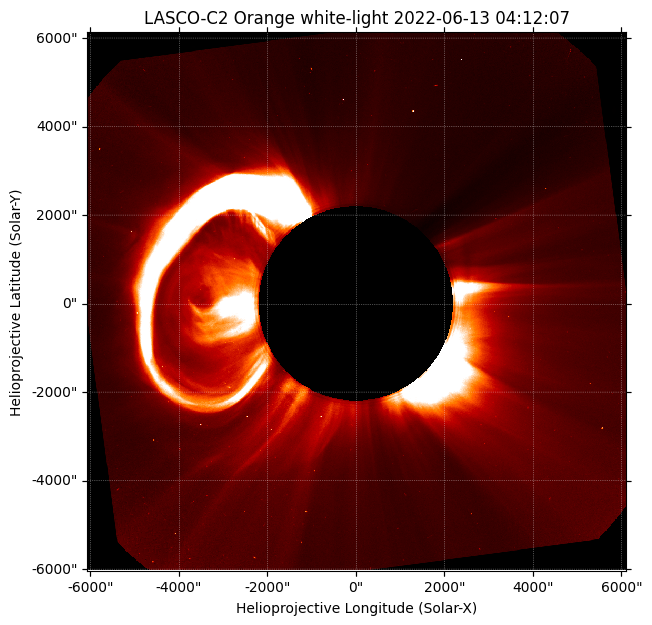

In [164]:
lasco_map = Map(lasco_jp2_file)
plt.figure(figsize=[7,7])
lasco_map.plot()
plt.show()

In [165]:
# get AIA

import os
import glob
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
import sunpy.timeseries
import sunpy.map
from sunpy.time import parse_time
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

channel = 304 #171
result = Fido.search(a.Time(f'{select_year}-{select_month}-{select_day} {select_hour}:{select_minute}',
                            f'{select_year}-{select_month}-{select_day} {select_hour}:{select_minute+1}'),
                            a.Instrument('AIA'), 
                            a.Wavelength(channel*u.angstrom), 
                            a.Sample(1*u.min))

In [166]:
# make nested directories recursively
os.makedirs(f'/SSD/{select_year}{select_month}{select_day}/AIA/{channel}/', exist_ok=True)

In [167]:
aia_files = Fido.fetch(result, path=f'/SSD/{select_year}{select_month}{select_day}/AIA/{channel}/')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [168]:
local_dir = f'/SSD/{select_year}{select_month}{select_day}/AIA/{channel}'
aia_fit = sorted(glob.glob(f'{local_dir}/*.fits'))

In [169]:
from aiapy.calibrate import normalize_exposure, register, update_pointing
import astropy.io.fits as fits
import matplotlib.colors as colors
from astropy.visualization import ImageNormalize, SqrtStretch

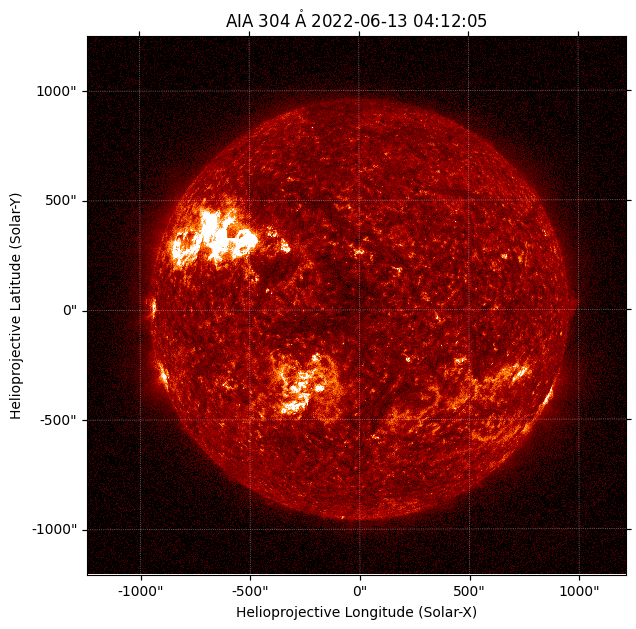

In [170]:
aia_map = sunpy.map.Map(aia_fit)
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=70, stretch=SqrtStretch())
plt.figure(figsize=[7,7])
aia_map.plot()
plt.show()

In [171]:
projected_coord = SkyCoord(0*u.arcsec, 0*u.arcsec,
                           obstime=lasco_map.observer_coordinate.obstime,
                           frame='helioprojective',
                           observer=lasco_map.observer_coordinate,
                           rsun=aia_map.coordinate_frame.rsun)

projected_header = sunpy.map.make_fitswcs_header(aia_map.data.shape,
                                                 projected_coord,
                                                 scale=u.Quantity(aia_map.scale),
                                                 instrument=aia_map.instrument,
                                                 wavelength=aia_map.wavelength)

# We use `assume_spherical_screen` to ensure that the off limb AIA pixels are reprojected
# otherwise it will only be the on disk pixels that are reprojected.
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    aia_reprojected = aia_map.reproject_to(projected_header)

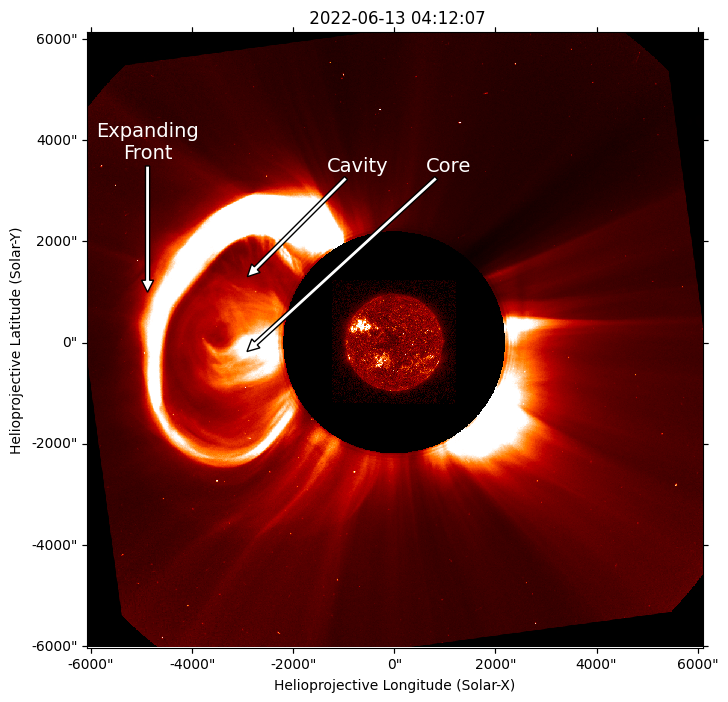

In [173]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection=lasco_map)
lasco_map.plot(axes=ax)
aia_reprojected.plot(axes=ax, autoalign=True)
# ax.set_title('')

# Add arrows with text
ax.arrow(100, 800, 0, -190, head_width=20, head_length=20, width=7, fc='white', ec='black')
ax.text(100, 840, 'Expanding\nFront', fontsize=14, color='white', ha='center', va='center')

ax.arrow(430, 780, -150, -150, head_width=20, head_length=20, width=7, fc='white', ec='black')
ax.text(450, 800, 'Cavity', fontsize=14, color='white', ha='center', va='center')

ax.arrow(580, 780, -300, -275, head_width=20, head_length=20, width=7, fc='white', ec='black')
ax.text(600, 800, 'Core', fontsize=14, color='white', ha='center', va='center')

ax.grid(alpha=0.7)
fig.savefig(f'./AIA_LASCO_composite_{select_year}{select_month}{select_day}.png', bbox_inches='tight')
plt.show()

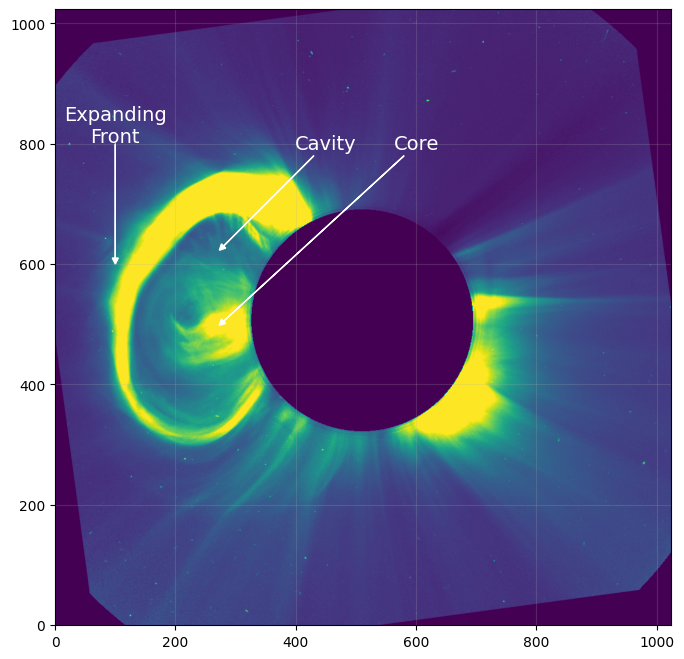

In [97]:
plt.figure(figsize=[8,8])
plt.imshow(lasco_map.data)
ax = plt.gca()
ax.invert_yaxis()

# Add arrows with text
ax.arrow(100, 800, 0, -190, head_width=10, head_length=10, fc='white', ec='white')
ax.text(100, 830, 'Expanding\nFront', fontsize=14, color='white', ha='center', va='center')

ax.arrow(430, 780, -150, -150, head_width=10, head_length=10, fc='white', ec='white')
ax.text(450, 800, 'Cavity', fontsize=14, color='white', ha='center', va='center')

ax.arrow(580, 780, -300, -275, head_width=10, head_length=10, fc='white', ec='white')
ax.text(600, 800, 'Core', fontsize=14, color='white', ha='center', va='center')

plt.grid(alpha=0.2)
plt.show()